In [95]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = float(xmax-xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        # convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))

        # create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        # create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) , batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [111]:
ts_data = TimeSeriesData(250, 0, 10)

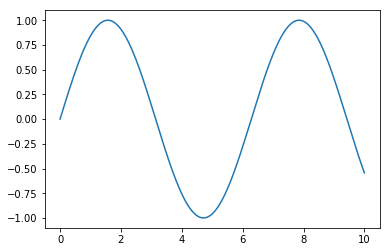

In [112]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [113]:
# Number of steps in batch
num_time_steps = 30

In [114]:
y1,y2,ts = ts_data.next_batch(1, num_time_steps, True)

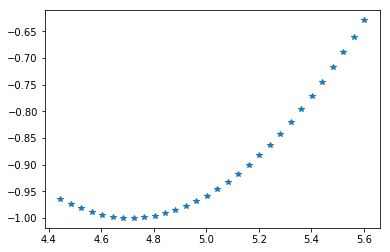

In [115]:
plt.plot(ts.flatten()[1:], y2.flatten(),'*')

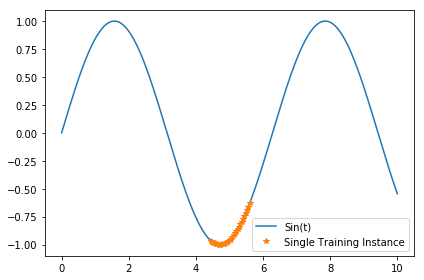

In [116]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single Training Instance')
plt.legend()
plt.tight_layout()

### Training Instance and predict

In [117]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

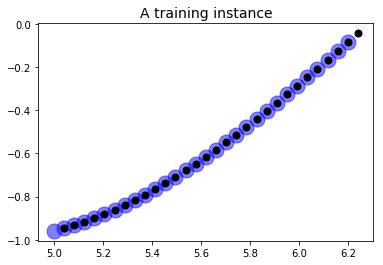

In [118]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

### Creating the Model

In [119]:
tf.reset_default_graph()

### Constants

In [120]:
# one feature, the time series
num_inputs = 1
# 100 neural layer
num_neurons = 100
# one output
num_outputs = 1
# learning rate, 0.0001 default
learning_rate = 0.0001
# iterations
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

### Placeholders

In [124]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

### RNN Cell Layer

In [125]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
        output_size=num_outputs)

### Dynamic RNN Cell

In [126]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [129]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init

In [131]:
init = tf.global_variables_initializer()

### Session

In [132]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [133]:
saver = tf.train.Saver()

In [134]:
#with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess: 
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts.data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")
            

AttributeError: 'buffer' object has no attribute 'next_batch'